In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import time

import lightgbm

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from matplotlib.pyplot import figure

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge

%matplotlib inline

In [2]:
rep_cols = {'ID':'ID', 
 '板温':'board_t', 
 '现场温度':'env_t', 
 '光照强度':'light_strength', 
 '转换效率':'efficiency', 
 '转换效率A':'efficiency_A', 
 '转换效率B':'efficiency_B', 
 '转换效率C':'efficiency_C', 
 '电压A':'V_A',
 '电压B':'V_B', 
 '电压C':'V_C', 
 '电流A':'I_A', 
 '电流B':'I_B', 
 '电流C':'I_C', 
 '功率A':'P_A', 
 '功率B':'P_B', 
 '功率C':'P_C', 
 '平均功率':'P_avg', 
 '风速':'wind_speed',
 '风向':'wind_direction', 
 '发电量':'y'
}

In [3]:
def my_val(preds, train_data):
    label = train_data.get_label()
    return 'score', 1/(1+np.sqrt(mean_squared_error(preds, label))), True
def my_obj(preds, train_data):
    labels = train_deata.get_label()

In [4]:
train = pd.read_csv('../data/public_raw.train.csv')
test = pd.read_csv('../data/public_raw.test.csv')

train_len = train.shape[0]

train['is_train']=1
test['is_train']=0

df = pd.concat([train, test],sort=False)

In [5]:
df.rename(index=str, columns=rep_cols, inplace=True)

df.sort_values(by=['ID'],ascending=True, inplace=True)

df.reset_index(drop=True, inplace=True)

In [6]:
train = df[df['is_train']==1]
test = df[df['is_train']==0]

x=train[['ID']]
y=train[['y']]

In [7]:
#前二后二
next_one = []
prev_one = []
next_id = []
prev_id = []

second_next_one = []
second_prev_one = []

df_len = df.shape[0]

i_y =df.columns.get_loc("y")

def get_prev_nn_index(cur_i):
    prev_i = cur_i-1
    while(prev_i>=0 and pd.isnull(df.iat[prev_i,i_y])):
        prev_i-=1
    return prev_i

def get_next_nn_index(cur_i):
    prev_i = cur_i+1
    while(prev_i<df_len and pd.isnull(df.iat[prev_i,i_y])):
        prev_i+=1
    return prev_i

for i in range(df_len):
    f_pre_i=get_prev_nn_index(i)
    if(f_pre_i)<0:
        prev_one.append(np.nan)
        prev_id.append(0)
    else:
        prev_one.append(df.iat[f_pre_i,i_y])
        prev_id.append(f_pre_i)
        
    s_pre_i=get_prev_nn_index(f_pre_i)
    if (s_pre_i)<0:
        second_prev_one.append(np.nan)
    else:
        second_prev_one.append(df.iat[s_pre_i,i_y])
    
    f_next_i=get_next_nn_index(i)
    if(f_next_i<df_len):
        next_one.append(df.iat[f_next_i,i_y])
        next_id.append(f_next_i)
    else:
        next_one.append(np.nan)
        next_id.append(df_len)
    
    s_next_i=get_next_nn_index(f_next_i)
    if(s_next_i<df_len):
        second_next_one.append(df.iat[s_next_i,i_y])
    else:
        second_next_one.append(np.nan)

In [8]:
df['next_value'] = next_one
df['prev_value'] = prev_one
df['avg_value'] = np.nanmean([df['next_value'], df['prev_value']],axis=0)
df['next_ID'] = next_id
df['prev_ID'] = prev_id
# df['interpolation_ID'] = df['prev_value']+(df['ID']-df['prev_ID'])/(df['next_ID']-df['prev_ID'])*(df['next_value']-df['prev_value'])
# df['interpolation_ls'] = df['prev_value']+(df['light_strength']-df['prev_ls'])/(1+df['next_ls']-df['prev_ls'])*(df['next_value']-df['prev_value'])

df['second_prev_value'] = second_prev_one
df['second_next_value'] = second_next_one
# df['avg_value_four'] = np.nanmean([df['second_next_value'],df['next_value'], df['prev_value'],df['second_prev_value']],axis=0)


# df['rolling_seven'] = df['y'].rolling(7,center=True,min_periods=0).apply(lambda x: np.nanmean(x[[0,1,2,4,5,6]]))
rolling_mask_two = [-i for i in range(1,2)]+[i for i in range(1,2)]
rolling_mask_four = [-i for i in range(1,3)]+[i for i in range(1,3)]
rolling_mask_six = [-i for i in range(1,4)]+[i for i in range(1,4)]
rolling_mask_eight = [-i for i in range(1,5)]+[i for i in range(1,5)]
# df['rolling_four_y'] = np.nanmean([df['y'].shift(i) for i in rolling_mask_four],axis=0)
# df['rolling_six_y'] = np.nanmean([df['y'].shift(i) for i in rolling_mask_six],axis=0)
df['rolling_six_y'] = np.nanmean([df['y'].shift(i) for i in rolling_mask_six],axis=0)

C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice


In [9]:
df['magic_feature'] = df['ID']%190

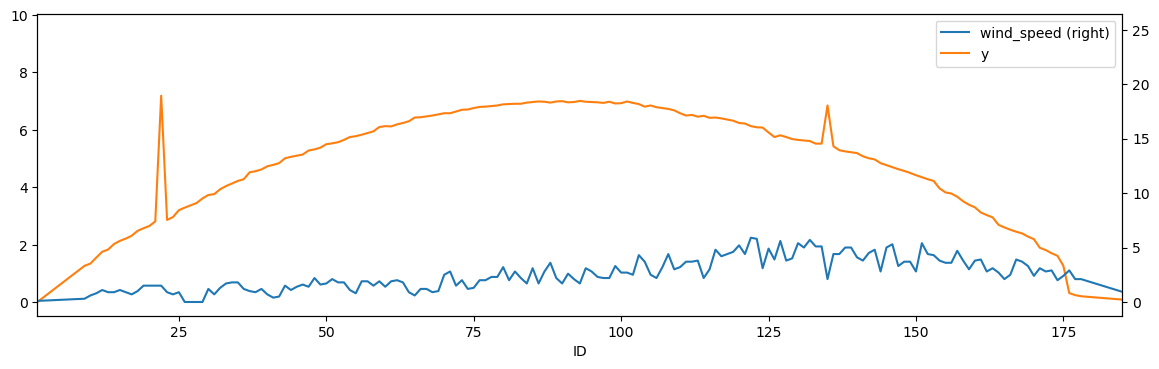

In [10]:
#问题4：ID和wind_speed的关系？
#回答：

figure(num=None, figsize=(14,4), dpi=100, facecolor='w', edgecolor='k')

ax = plt.gca()

dfp=df
# dfp.plot(x='ID',y='wind_speed',ax=ax)
# dfp.plot(x='ID',xlim=(750,900),y='wind_direction',ax=ax)
n=0
p=185
dfp.plot(x='ID',xlim=(n*p+1,(n+1)*p),y='wind_speed',secondary_y=True,ax=ax)
dfp.plot(x='ID',y='I_A',label='y',ax=ax)

# dfp.plot(x='ID',y='y',label='y',ax=ax)


plt.show()

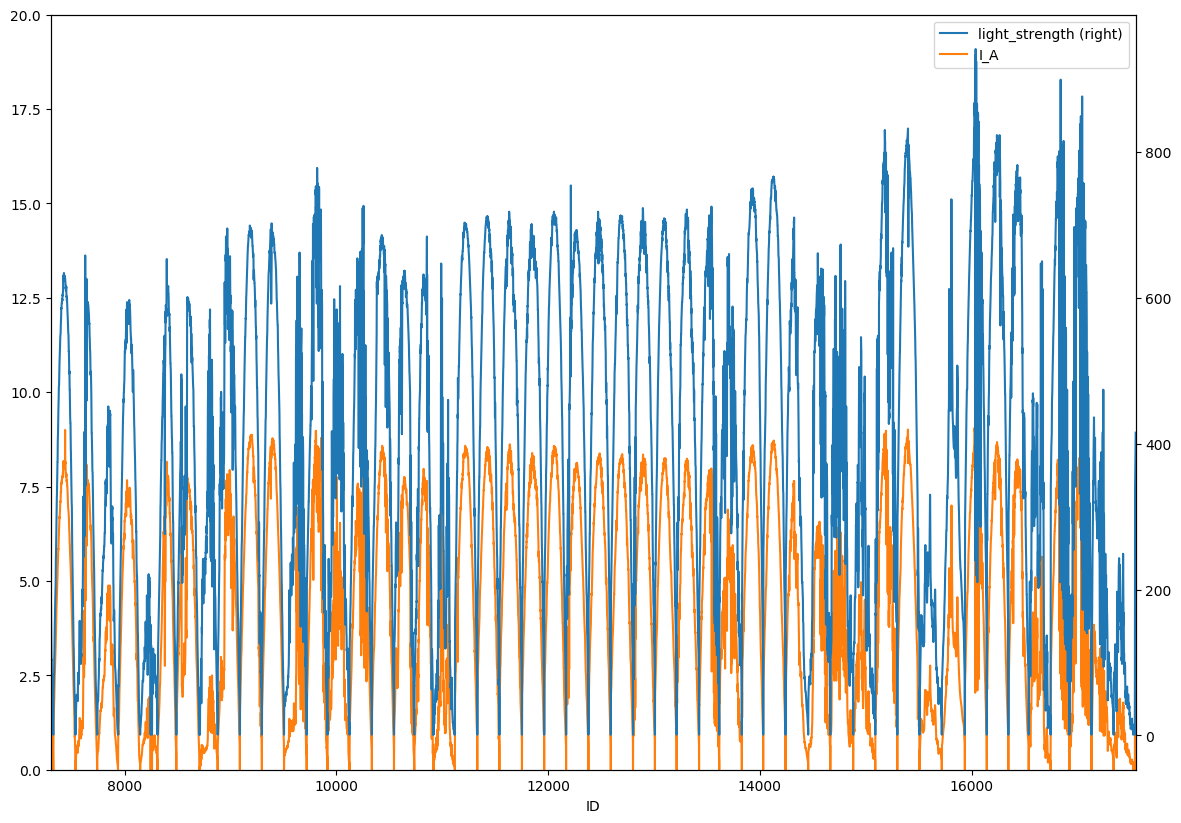

In [11]:
#问题2.5：电流和light_strength的关系？
#回答2.5：

figure(num=None, figsize=(14,10), dpi=100, facecolor='w', edgecolor='k')

ax = plt.gca()

dfp=df
dfp.plot(x='ID',xlim=(7300,17550),y='light_strength',secondary_y=True,ax=ax)
dfp.plot(x='ID',y='I_A',ylim=(0,20),label='I_A',ax=ax)

# dfp.plot(x='ID',y='y',label='y',ax=ax)


plt.show()

In [12]:
# 辐照强度做bin
light_bin_ranges = [-1, 620, 1000]
light_bin_names = [0, 1]
df['light_bin_custom_range'] = pd.cut(
                                           np.array(
                                              df['light_strength']), 
                                              bins=light_bin_ranges)
df['light_bin_custom_label'] = pd.cut(
                                           np.array(
                                              df['light_strength']), 
                                              bins=light_bin_ranges,            
                                              labels=light_bin_names)

df['light_level']=pd.to_numeric(df['light_bin_custom_label'])

In [13]:
#根据风速和风向的方差做bin
rolling_mask_12 = [-i for i in range(1,7)]+[i for i in range(1,7)]

df['std_direction'] = np.nanstd([df['wind_direction'].shift(i) for i in rolling_mask_12],axis=0)

df['std_speed'] = np.nanstd([df['wind_speed'].shift(i) for i in rolling_mask_12],axis=0)



direction_bin_ranges = [0, 83, 170]
direction_bin_names = [0, 1]
df['Direction_bin_custom_range'] = pd.cut(
                                           np.array(
                                              df['std_direction']), 
                                              bins=direction_bin_ranges)
df['Direction_bin_custom_label'] = pd.cut(
                                           np.array(
                                              df['std_direction']), 
                                              bins=direction_bin_ranges,            
                                              labels=direction_bin_names)

df['direction_level']=pd.to_numeric(df['Direction_bin_custom_label'])




speed_bin_ranges = [0, 1.02, 7]
speed_bin_names = [0, 1]
df['Speed_bin_custom_range'] = pd.cut(
                                           np.array(
                                              df['std_speed']), 
                                              bins=speed_bin_ranges)
df['Speed_bin_custom_label'] = pd.cut(
                                           np.array(
                                              df['std_speed']), 
                                              bins=speed_bin_ranges,            
                                              labels=speed_bin_names)


df['speed_level']=pd.to_numeric(df['Speed_bin_custom_label'])

In [14]:
df['is_sunny'] = 1

In [15]:
df.loc[(df['speed_level']==1)&(df['direction_level']==1) , ['is_sunny']] = 0

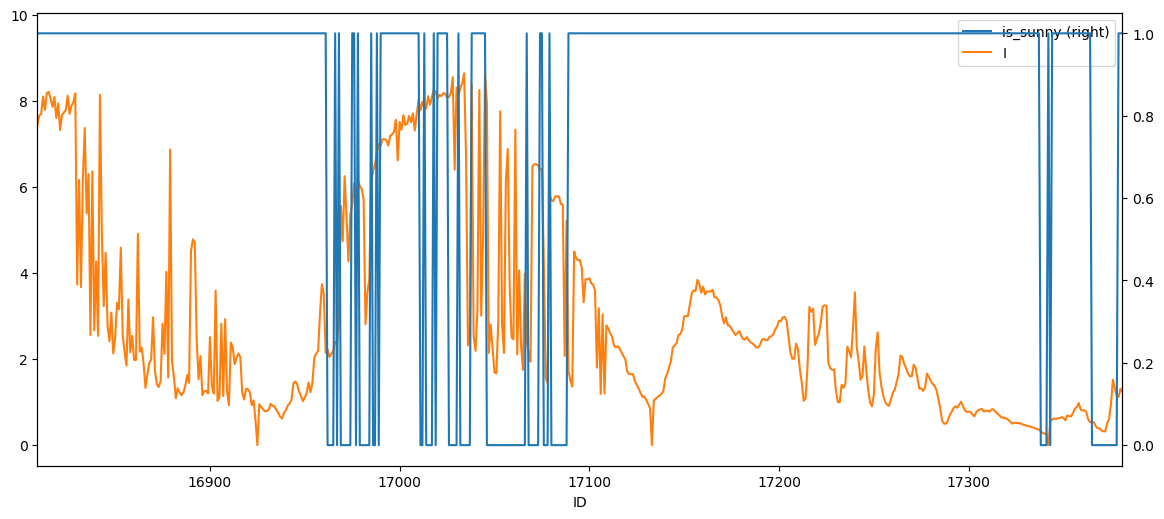

In [16]:
#问题4：ID和wind_speed的关系？
#回答：

figure(num=None, figsize=(14,6), dpi=100, facecolor='w', edgecolor='k')

ax = plt.gca()

dfp=df
# dfp.plot(x='ID',y='wind_speed',ax=ax)
# dfp.plot(x='ID',xlim=(750,900),y='wind_direction',ax=ax)
n=88
p=191
dfp.plot(x='ID',xlim=(n*p+1,(n+3)*p),y='is_sunny',secondary_y=True,ax=ax)
# dfp.plot(x='ID',xlim=(16910,16928),y='wind_speed',secondary_y=True,ax=ax)
dfp.plot(x='ID',y='I_A',label='I',ax=ax)

# dfp.plot(x='ID',y='y',label='y',ax=ax)


plt.show()

In [17]:
train = df[df['is_train']==1]
test = df[df['is_train']==0]

In [18]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l2',
    'metric': 'mse',
    'num_leaves': 31,
    'learning_rate': 0.08,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'verbose': 0
}
# 同样的条件下，此参数设置达到local cv: 0.8575832021441638


test_predicts = []
val_preds = []

# log_test_predicts = []
# log_val_predicts = []
for idx, seed in enumerate([1,2,3,4,5]):
    kf = KFold(5, shuffle=True, random_state=seed)
    
    val_preds.append(np.zeros(train.shape[0]))
    for n_fold, (tra_idx, val_idx) in enumerate(kf.split(train)):
        tra = train.iloc[tra_idx]
        val = train.iloc[val_idx]
        tst = test.copy()

#         grouper = ['bin_ls','bin_env_t','bin_board_t']
#         x = tra.groupby(grouper)['y'].agg({'target_encoding_mean':'mean',
#                                            'target_encoding_max':'max',
#                                            'target_encoding_min':'min',
#                                            'target_encoding_median':'median',
#                                            'target_encoding_var':'var',
#                                            'target_encoding_count':'count'}).reset_index()
#         tra = tra.merge(x, on=grouper, how='left')
#         val = val.merge(x, on= grouper , how ='left')
#         tst = tst.merge(x, on=grouper, how='left')
        predictor = [c for c in tra.columns.tolist() if c not in['y','is_train']]

        train_set = lightgbm.Dataset(
            tra[predictor],
            tra['y']
        )

        validation_set = lightgbm.Dataset(
            val[predictor],
            val['y']
        )

        model = lightgbm.train(params, train_set, num_boost_round=5000,
                              valid_sets= [validation_set],
                              valid_names=['valid'],
                              early_stopping_rounds=100,
                               feval=my_val,
                              verbose_eval=500)

        val_preds[idx][val_idx] = model.predict(val[predictor])
        test_predicts.append(model.predict(tst[predictor]))

print('local cv:',1/(1+np.sqrt(mean_squared_error(train['y'],np.mean(val_preds,axis=0)))))

C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\lightgbm\basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[500]	valid's l2: 0.0582182	valid's score: 0.805617
Early stopping, best iteration is:
[808]	valid's l2: 0.0579181	valid's score: 0.806021
Training until validation scores don't improve for 100 rounds.
[500]	valid's l2: 0.0173414	valid's score: 0.883637
Early stopping, best iteration is:
[809]	valid's l2: 0.0169487	valid's score: 0.884809
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[235]	valid's l2: 0.0123348	valid's score: 0.90004
Training until validation scores don't improve for 100 rounds.
[500]	valid's l2: 0.0387727	valid's score: 0.835486
[1000]	valid's l2: 0.0377392	valid's score: 0.837334
Early stopping, best iteration is:
[1236]	valid's l2: 0.0375098	valid's score: 0.837749
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[249]	valid's l2: 0.0164173	valid's score: 0.886423
Training until validation scores don't im

In [19]:
#rolling时泄漏，因此线下达到0.86375，但是线上成绩只有0.7606     保留此CELL
pd.Series(model.feature_importance(importance_type='gain'),
          index=model.feature_name()).sort_values(ascending=False)

P_A                           188135.592156
I_A                            76723.321681
P_avg                          59399.638798
I_C                            56417.660940
P_C                            20874.152180
avg_value                      20392.535694
P_B                            11650.020130
I_B                             7015.864692
prev_value                      4319.293741
rolling_six_y                   4000.450809
light_strength                   313.349120
efficiency                       243.904440
next_value                       154.861216
second_prev_value                124.049549
second_next_value                113.576795
wind_direction                   108.395373
board_t                           96.951047
V_A                               87.367283
wind_speed                        75.670513
V_B                               67.021421
efficiency_C                      50.227194
V_C                               44.156840
env_t                           

In [20]:
test['ans'] = np.mean(test_predicts, axis=0)

for index, row in test.iterrows():
    if row['I_A'] == 0:
        test.at[index,'ans'] = 0.379993 
        print("Hi!"+str(index))

test[test['I_A']==0][['ID','I_A','V_A','V_B','V_C','ans']]

C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Hi!0
Hi!855
Hi!1543
Hi!1714
Hi!2583
Hi!2930
Hi!4123
Hi!4300
Hi!4462
Hi!4632
Hi!4633
Hi!4674
Hi!4675
Hi!4867
Hi!4870
Hi!5072
Hi!5463
Hi!5665
Hi!6071
Hi!6074
Hi!7684
Hi!7783
Hi!7848
Hi!8026
Hi!8624
Hi!8832
Hi!9041
Hi!9255
Hi!9452
Hi!9660
Hi!9871
Hi!10272
Hi!10453
Hi!10653
Hi!11497
Hi!13364
Hi!13566
Hi!13777
Hi!13991
Hi!14833
Hi!15042
Hi!15678
Hi!15882
Hi!16459
Hi!16876
Hi!17061


,ID,I_A,V_A,V_B,V_C,ans
0,1,0.0,0,0,0,0.379993
855,940,0.0,0,0,0,0.379993
1543,1694,0.0,0,0,0,0.379993
1714,1879,0.0,0,0,0,0.379993
2583,2823,0.0,0,0,0,0.379993
2930,3202,0.0,0,0,0,0.379993
4123,4459,0.0,0,0,0,0.379993
4300,4648,0.0,0,0,0,0.379993
4462,4821,0.0,0,0,0,0.379993
4632,5010,0.0,0,0,0,0.379993


In [21]:
#rolling时泄漏，因此线下达到0.86375，但是线上成绩只有0.7606
test[['ID','ans']].to_csv('../result/080803_086051.csv',header=False, index=False)